# 04 – Experiments: Model Comparison & Hyperparameter Sensitivity

Ziel: Systematischer Vergleich von (a) klassischer Baseline und (b) Transformer-Modellen
unter Variation ausgewählter Hyperparameter (Epochen, Sequenzlänge, Modellgröße).
Gemessen werden Performance (Accuracy/Macro-F1) und Effizienz (Trainingszeit).


In [1]:
from pathlib import Path
import time
import json
import numpy as np
import pandas as pd

PROJECT_ROOT = Path.cwd().parent
DATA_CSV = PROJECT_ROOT / "data" / "processed" / "bbc_news.csv"

RESULTS_DIR = PROJECT_ROOT / "results"
RESULTS_DIR.mkdir(exist_ok=True)

EXP_DIR = RESULTS_DIR / "experiments_hparams"
EXP_DIR.mkdir(exist_ok=True)

DATA_CSV, EXP_DIR


(WindowsPath('c:/CAS/cas-ml-document-classification/data/processed/bbc_news.csv'),
 WindowsPath('c:/CAS/cas-ml-document-classification/results/experiments_hparams'))

Daten laden und Split

In [2]:
from sklearn.model_selection import train_test_split

df = pd.read_csv(DATA_CSV)

labels_sorted = sorted(df["label"].unique())
label2id = {l:i for i,l in enumerate(labels_sorted)}
id2label = {i:l for l,i in label2id.items()}

X = df["text"].astype(str).values
y = df["label"].map(label2id).values

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

len(X_train), len(X_test), labels_sorted


(1780, 445, ['business', 'entertainment', 'politics', 'sport', 'tech'])

Baseline einmal rechnen: TF-IDF + LogReg

In [3]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

baseline = Pipeline([
    ("tfidf", TfidfVectorizer(max_features=50000, ngram_range=(1,2), stop_words="english")),
    ("clf", LogisticRegression(max_iter=2000, n_jobs=-1))
])

t0 = time.time()
baseline.fit(X_train, y_train)
train_time = time.time() - t0

pred = baseline.predict(X_test)

baseline_acc = accuracy_score(y_test, pred)
baseline_f1 = f1_score(y_test, pred, average="macro")

baseline_result = {
    "run_name": "baseline_logreg",
    "model": "tfidf+logreg",
    "epochs": None,
    "max_length": None,
    "learning_rate": None,
    "batch_size": None,
    "train_time_sec": round(train_time, 2),
    "test_accuracy": round(float(baseline_acc), 4),
    "test_macro_f1": round(float(baseline_f1), 4),
}
baseline_result


{'run_name': 'baseline_logreg',
 'model': 'tfidf+logreg',
 'epochs': None,
 'max_length': None,
 'learning_rate': None,
 'batch_size': None,
 'train_time_sec': 2.31,
 'test_accuracy': 0.991,
 'test_macro_f1': 0.9912}

Helper: Metrics Function

In [4]:
from sklearn.metrics import precision_score, recall_score

def compute_metrics_np(y_true, y_pred):
    return {
        "test_accuracy": round(float(accuracy_score(y_true, y_pred)), 4),
        "test_macro_f1": round(float(f1_score(y_true, y_pred, average="macro")), 4),
        "test_macro_precision": round(float(precision_score(y_true, y_pred, average="macro", zero_division=0)), 4),
        "test_macro_recall": round(float(recall_score(y_true, y_pred, average="macro", zero_division=0)), 4),
    }


BERT Training Runner – einmal sauber kapseln (CUDA wichtig)

In [5]:
import torch
from transformers import (
    AutoTokenizer, 
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer
)
from datasets import Dataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [6]:
def run_transformer_experiment(
    run_name: str,
    model_name: str,
    max_length: int = 128,
    epochs: int = 3,
    learning_rate: float = 2e-5,
    batch_size: int = 16,
    seed: int = 42
):
    # Dataset -> HF Dataset
    train_ds = Dataset.from_dict({"text": list(X_train), "label": list(y_train)})
    test_ds  = Dataset.from_dict({"text": list(X_test),  "label": list(y_test)})

    tokenizer = AutoTokenizer.from_pretrained(model_name)

    def tokenize(batch):
        return tokenizer(
            batch["text"],
            truncation=True,
            padding="max_length",
            max_length=max_length
        )

    train_tok = train_ds.map(tokenize, batched=True)
    test_tok  = test_ds.map(tokenize, batched=True)

    # Format für PyTorch
    train_tok.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
    test_tok.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=len(labels_sorted),
        id2label=id2label,
        label2id=label2id
    ).to(device)

    args = TrainingArguments(
        output_dir=str(EXP_DIR / run_name),
        num_train_epochs=epochs,
        learning_rate=learning_rate,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        evaluation_strategy="epoch",
        save_strategy="no",
        logging_strategy="epoch",
        seed=seed,
        report_to="none"
    )

    def compute_metrics(eval_pred):
        logits, labels = eval_pred
        preds = np.argmax(logits, axis=1)
        return compute_metrics_np(labels, preds)

    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=train_tok,
        eval_dataset=test_tok,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics
    )

    t0 = time.time()
    trainer.train()
    train_time = time.time() - t0

    eval_res = trainer.evaluate()
    # eval_res keys: eval_accuracy, eval_macro_f1,... je nach compute_metrics
    result = {
        "run_name": run_name,
        "model": model_name,
        "epochs": epochs,
        "max_length": max_length,
        "learning_rate": learning_rate,
        "batch_size": batch_size,
        "train_time_sec": round(train_time, 2),
        "test_accuracy": round(float(eval_res.get("eval_test_accuracy", eval_res.get("eval_accuracy", np.nan))), 4),
        "test_macro_f1": round(float(eval_res.get("eval_test_macro_f1", eval_res.get("eval_macro_f1", np.nan))), 4),
        "test_macro_precision": round(float(eval_res.get("eval_test_macro_precision", eval_res.get("eval_macro_precision", np.nan))), 4),
        "test_macro_recall": round(float(eval_res.get("eval_test_macro_recall", eval_res.get("eval_macro_recall", np.nan))), 4),
    }
    return result


Experiment-Plan definieren

In [7]:
experiment_plan = [
    # BERT base – Epochs Vergleich
    {"run_name": "bert_base_e2_len128", "model_name": "bert-base-uncased", "epochs": 2, "max_length": 128},
    {"run_name": "bert_base_e3_len128", "model_name": "bert-base-uncased", "epochs": 3, "max_length": 128},

    # Max length Vergleich (nur wenn GPU ok)
    {"run_name": "bert_base_e2_len256", "model_name": "bert-base-uncased", "epochs": 2, "max_length": 256},

    # DistilBERT Speed/Acc Trade-off
    {"run_name": "distilbert_e3_len128", "model_name": "distilbert-base-uncased", "epochs": 3, "max_length": 128},
]
experiment_plan


[{'run_name': 'bert_base_e2_len128',
  'model_name': 'bert-base-uncased',
  'epochs': 2,
  'max_length': 128},
 {'run_name': 'bert_base_e3_len128',
  'model_name': 'bert-base-uncased',
  'epochs': 3,
  'max_length': 128},
 {'run_name': 'bert_base_e2_len256',
  'model_name': 'bert-base-uncased',
  'epochs': 2,
  'max_length': 256},
 {'run_name': 'distilbert_e3_len128',
  'model_name': 'distilbert-base-uncased',
  'epochs': 3,
  'max_length': 128}]

Runs ausführen + Resultate sammeln

In [8]:
results = []
results.append(baseline_result)

for exp in experiment_plan:
    print("Running:", exp["run_name"])
    res = run_transformer_experiment(
        run_name=exp["run_name"],
        model_name=exp["model_name"],
        epochs=exp["epochs"],
        max_length=exp["max_length"],
        learning_rate=2e-5,
        batch_size=16
    )
    results.append(res)

df_runs = pd.DataFrame(results)
df_runs


Running: bert_base_e2_len128


c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/1780 [00:00<?, ? examples/s]

Map:   0%|          | 0/445 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


  0%|          | 0/224 [00:00<?, ?it/s]

{'loss': 0.6383, 'grad_norm': 15.114649772644043, 'learning_rate': 1e-05, 'epoch': 1.0}


  0%|          | 0/28 [00:00<?, ?it/s]

{'eval_loss': 0.11828837543725967, 'eval_test_accuracy': 0.9798, 'eval_test_macro_f1': 0.9798, 'eval_test_macro_precision': 0.9786, 'eval_test_macro_recall': 0.9814, 'eval_runtime': 0.5264, 'eval_samples_per_second': 845.318, 'eval_steps_per_second': 53.189, 'epoch': 1.0}
{'loss': 0.0895, 'grad_norm': 0.43130138516426086, 'learning_rate': 0.0, 'epoch': 2.0}


  0%|          | 0/28 [00:00<?, ?it/s]

{'eval_loss': 0.06716319173574448, 'eval_test_accuracy': 0.9888, 'eval_test_macro_f1': 0.9892, 'eval_test_macro_precision': 0.989, 'eval_test_macro_recall': 0.9894, 'eval_runtime': 0.5106, 'eval_samples_per_second': 871.525, 'eval_steps_per_second': 54.838, 'epoch': 2.0}
{'train_runtime': 16.1116, 'train_samples_per_second': 220.959, 'train_steps_per_second': 13.903, 'train_loss': 0.36392566561698914, 'epoch': 2.0}


  0%|          | 0/28 [00:00<?, ?it/s]

Running: bert_base_e3_len128


c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/1780 [00:00<?, ? examples/s]

Map:   0%|          | 0/445 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


  0%|          | 0/336 [00:00<?, ?it/s]

{'loss': 0.6827, 'grad_norm': 10.660295486450195, 'learning_rate': 1.3333333333333333e-05, 'epoch': 1.0}


  0%|          | 0/28 [00:00<?, ?it/s]

{'eval_loss': 0.1066831424832344, 'eval_test_accuracy': 0.9865, 'eval_test_macro_f1': 0.9869, 'eval_test_macro_precision': 0.9864, 'eval_test_macro_recall': 0.9874, 'eval_runtime': 0.5213, 'eval_samples_per_second': 853.639, 'eval_steps_per_second': 53.712, 'epoch': 1.0}
{'loss': 0.0747, 'grad_norm': 0.3605765104293823, 'learning_rate': 6.666666666666667e-06, 'epoch': 2.0}


  0%|          | 0/28 [00:00<?, ?it/s]

{'eval_loss': 0.03987429291009903, 'eval_test_accuracy': 0.9955, 'eval_test_macro_f1': 0.9954, 'eval_test_macro_precision': 0.9951, 'eval_test_macro_recall': 0.9957, 'eval_runtime': 0.5083, 'eval_samples_per_second': 875.393, 'eval_steps_per_second': 55.081, 'epoch': 2.0}
{'loss': 0.0309, 'grad_norm': 0.21521495282649994, 'learning_rate': 0.0, 'epoch': 3.0}


  0%|          | 0/28 [00:00<?, ?it/s]

{'eval_loss': 0.0338776521384716, 'eval_test_accuracy': 0.9955, 'eval_test_macro_f1': 0.9957, 'eval_test_macro_precision': 0.9957, 'eval_test_macro_recall': 0.9957, 'eval_runtime': 0.5136, 'eval_samples_per_second': 866.497, 'eval_steps_per_second': 54.521, 'epoch': 3.0}
{'train_runtime': 24.0349, 'train_samples_per_second': 222.176, 'train_steps_per_second': 13.98, 'train_loss': 0.26279020451364066, 'epoch': 3.0}


  0%|          | 0/28 [00:00<?, ?it/s]

Running: bert_base_e2_len256


c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/1780 [00:00<?, ? examples/s]

Map:   0%|          | 0/445 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


  0%|          | 0/224 [00:00<?, ?it/s]

{'loss': 0.6873, 'grad_norm': 25.572328567504883, 'learning_rate': 1e-05, 'epoch': 1.0}


  0%|          | 0/28 [00:00<?, ?it/s]

{'eval_loss': 0.14419758319854736, 'eval_test_accuracy': 0.9708, 'eval_test_macro_f1': 0.9704, 'eval_test_macro_precision': 0.9694, 'eval_test_macro_recall': 0.9731, 'eval_runtime': 1.0098, 'eval_samples_per_second': 440.678, 'eval_steps_per_second': 27.728, 'epoch': 1.0}
{'loss': 0.0796, 'grad_norm': 0.5269003510475159, 'learning_rate': 0.0, 'epoch': 2.0}


  0%|          | 0/28 [00:00<?, ?it/s]

{'eval_loss': 0.06508929282426834, 'eval_test_accuracy': 0.9888, 'eval_test_macro_f1': 0.9889, 'eval_test_macro_precision': 0.9885, 'eval_test_macro_recall': 0.9894, 'eval_runtime': 1.0172, 'eval_samples_per_second': 437.496, 'eval_steps_per_second': 27.528, 'epoch': 2.0}
{'train_runtime': 28.4985, 'train_samples_per_second': 124.919, 'train_steps_per_second': 7.86, 'train_loss': 0.3834521770477295, 'epoch': 2.0}


  0%|          | 0/28 [00:00<?, ?it/s]

Running: distilbert_e3_len128


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\tanja\.cache\huggingface\hub\models--distilbert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/1780 [00:00<?, ? examples/s]

Map:   0%|          | 0/445 [00:00<?, ? examples/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\CAS\cas-ml-document-classification\.venv\Lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


  0%|          | 0/336 [00:00<?, ?it/s]

{'loss': 0.6513, 'grad_norm': 15.344715118408203, 'learning_rate': 1.3333333333333333e-05, 'epoch': 1.0}


  0%|          | 0/28 [00:00<?, ?it/s]

{'eval_loss': 0.14984174072742462, 'eval_test_accuracy': 0.973, 'eval_test_macro_f1': 0.9731, 'eval_test_macro_precision': 0.9718, 'eval_test_macro_recall': 0.9752, 'eval_runtime': 0.3013, 'eval_samples_per_second': 1476.984, 'eval_steps_per_second': 92.934, 'epoch': 1.0}
{'loss': 0.0956, 'grad_norm': 0.39623790979385376, 'learning_rate': 6.666666666666667e-06, 'epoch': 2.0}


  0%|          | 0/28 [00:00<?, ?it/s]

{'eval_loss': 0.08876219391822815, 'eval_test_accuracy': 0.9775, 'eval_test_macro_f1': 0.9778, 'eval_test_macro_precision': 0.9766, 'eval_test_macro_recall': 0.98, 'eval_runtime': 0.2968, 'eval_samples_per_second': 1499.405, 'eval_steps_per_second': 94.345, 'epoch': 2.0}
{'loss': 0.049, 'grad_norm': 0.24130824208259583, 'learning_rate': 0.0, 'epoch': 3.0}


  0%|          | 0/28 [00:00<?, ?it/s]

{'eval_loss': 0.05959492549300194, 'eval_test_accuracy': 0.982, 'eval_test_macro_f1': 0.9823, 'eval_test_macro_precision': 0.9814, 'eval_test_macro_recall': 0.9835, 'eval_runtime': 0.3049, 'eval_samples_per_second': 1459.306, 'eval_steps_per_second': 91.821, 'epoch': 3.0}
{'train_runtime': 13.1803, 'train_samples_per_second': 405.149, 'train_steps_per_second': 25.493, 'train_loss': 0.26530806791214717, 'epoch': 3.0}


  0%|          | 0/28 [00:00<?, ?it/s]

,run_name,model,epochs,max_length,learning_rate,batch_size,train_time_sec,test_accuracy,test_macro_f1,test_macro_precision,test_macro_recall
0,baseline_logreg,tfidf+logreg,NaN,NaN,NaN,NaN,2.31,0.9910,0.9912,NaN,NaN
1,bert_base_e2_len128,bert-base-uncased,2.0,128.0,0.00002,16.0,16.57,0.9888,0.9892,0.9890,0.9894
2,bert_base_e3_len128,bert-base-uncased,3.0,128.0,0.00002,16.0,24.14,0.9955,0.9957,0.9957,0.9957
3,bert_base_e2_len256,bert-base-uncased,2.0,256.0,0.00002,16.0,28.60,0.9888,0.9889,0.9885,0.9894
4,distilbert_e3_len128,distilbert-base-uncased,3.0,128.0,0.00002,16.0,13.29,0.9820,0.9823,0.9814,0.9835


Speichern

In [9]:
out_csv = EXP_DIR / "exp_runs.csv"
df_runs.to_csv(out_csv, index=False)
out_csv


WindowsPath('c:/CAS/cas-ml-document-classification/results/experiments_hparams/exp_runs.csv')

Plots: Accuracy und Trainingszeit

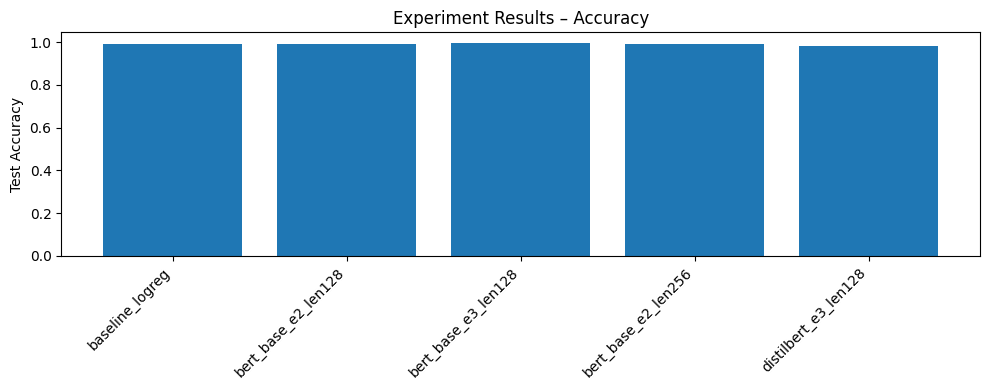

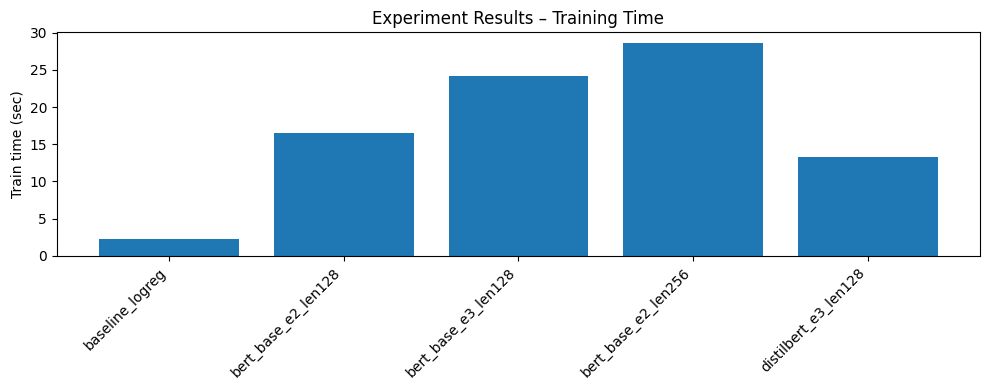

(WindowsPath('c:/CAS/cas-ml-document-classification/results/experiments_hparams/exp_accuracy.png'),
 WindowsPath('c:/CAS/cas-ml-document-classification/results/experiments_hparams/exp_train_time.png'))

: 

In [ ]:
import matplotlib.pyplot as plt

plot_df = df_runs.copy()
plot_df["short_model"] = plot_df["model"].apply(lambda x: x.split("/")[-1] if isinstance(x, str) else x)

# Accuracy plot
plt.figure(figsize=(10,4))
plt.bar(plot_df["run_name"], plot_df["test_accuracy"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Test Accuracy")
plt.title("Experiment Results – Accuracy")
plt.tight_layout()
acc_path = EXP_DIR / "exp_accuracy.png"
plt.savefig(acc_path, dpi=300)
plt.show()

# Time plot
plt.figure(figsize=(10,4))
plt.bar(plot_df["run_name"], plot_df["train_time_sec"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Train time (sec)")
plt.title("Experiment Results – Training Time")
plt.tight_layout()
time_path = EXP_DIR / "exp_train_time.png"
plt.savefig(time_path, dpi=300)
plt.show()

acc_path, time_path


## Kurzinterpretation

- Die Baseline (TF-IDF + Logistic Regression) erreicht auf dem BBC News Dataset sehr hohe Werte,
  was auf die klare thematische Trennung und starke Schlüsselwörter hindeutet.
- BERT erreicht ebenfalls sehr hohe Performance, benötigt jedoch deutlich mehr Rechenzeit.
- Der Vergleich von Epochen zeigt typischerweise: mehr Training hilft bis zu einem Plateau, danach kaum Gewinn.
- DistilBERT zeigt den erwarteten Trade-off: geringfügig weniger Performance bei deutlich schnellerem Training.
